In [1]:
%load_ext autoreload
%autoreload 2

This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
 

In [2]:
%run 0_parameters.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2019-03-12
{'batch_size': 100, 'test_batch_size': 1000, 'cmin': 0.1307, 'cmax': 0.3081, 'N_pic': 128, 'minibatch_size': 100, 'offset_std': 30, 'offset_max': 35, 'noise': 1.0, 'contrast': 0.4, 'sf_0': 0.2, 'B_sf': 0.3, 'N_theta': 6, 'N_azimuth': 16, 'N_eccentricity': 10, 'N_phase': 2, 'N_X': 128, 'N_Y': 128, 'rho': 1.41, 'lr': 0.0001, 'verbose': 1, 'filename': '../data/2019-03-12', 'seed': 2019}


In [3]:
figname = '../paper/fig_intro'

# process generating display images

In [4]:
from retina import Display
d = Display(args)
data, label = next(iter(d.loader_test))

In [5]:
print('data.shape=', data.shape)

data.shape= torch.Size([1000, 1, 28, 28])


## loading the MNIST dataset

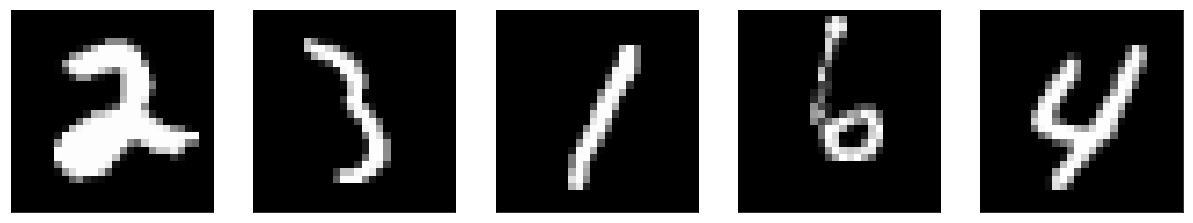

In [6]:
N_plot = 5
fig, axs = plt.subplots(1, N_plot, figsize = (21, 5))
for i_ax, ax in enumerate(axs):
    ax.imshow(data[i_ax, 0, :, :], cmap=plt.gray())
    ax.set_xticks([])
    ax.set_yticks([])

## placing the digits in some random noise

In [7]:
from retina import minmax, place_object

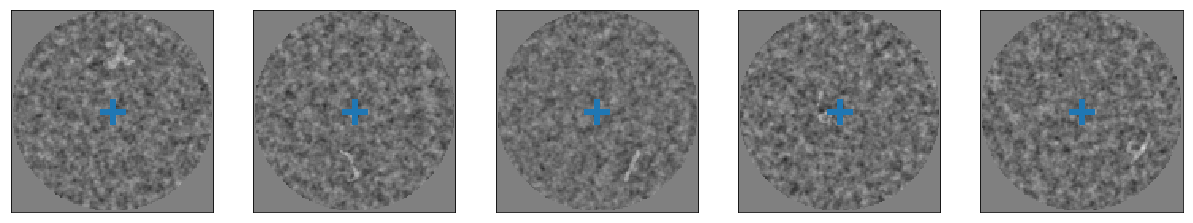

In [8]:
N_plot = 5
fig, axs = plt.subplots(1, N_plot, figsize = (21, 8))
for i_ax, ax in enumerate(axs):
    data_fullfield, i_offset, j_offset = d.draw(data[i_ax, 0, :, :].numpy())
    ax = d.show(ax, data_fullfield)


In [9]:
idx = 4
i_offset, j_offset = -29, 21

In [10]:
#data_fullfield, i_offset, j_offset = d.draw(data[0, 0, :, :].numpy())
data_fullfield = d.place_object(data[idx, 0, :, :].numpy(), i_offset, j_offset)

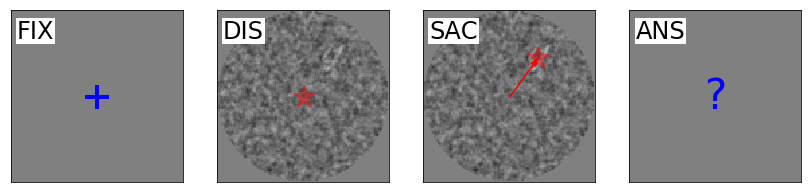

In [11]:
texts = ['FIX', 'DIS', 'SAC', 'ANS']
def panel_A(fig=None, axs=None):

    N_plot = 4

    if fig is None:
        fig, axs = plt.subplots(1, N_plot, figsize = (figwidth, figwidth/4))
    for ax, text in zip(axs, texts):
        ax.imshow(.5 + np.zeros_like(data_fullfield), cmap=plt.gray(), vmin=0, vmax=1)
        if text=='FIX': 
            ax.plot([args.N_pic//2], [args.N_pic//2], '+', color='b', ms=24, markeredgewidth=4)
        elif text in ['DIS', 'SAC']: 
            ax.imshow(data_fullfield, cmap=plt.gray(), vmin=0, vmax=1)
            opts = dict(ms=24, markeredgewidth=1, alpha=.4)
            if text == 'DIS':
                ax.plot([args.N_pic//2], [args.N_pic//2], '*r', **opts)
            else:
                ax.plot([args.N_pic//2+j_offset], [args.N_pic//2+i_offset], '*r', **opts)
                ax.arrow(args.N_pic//2, args.N_pic//2, j_offset, i_offset, width=.3, color='r', 
                         head_width=4., length_includes_head=True, edgecolor='k')
        elif text=='ANS':         
            ax.text(args.N_pic//2, args.N_pic//2, '?', color='b', fontsize=42,
              ha='center', va='center')

        ax.set_xticks([])
        ax.set_yticks([])
        ax.text(4, 15, text, fontsize=24,
              bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
              ha='left', va='center') 

    # TODO: show arrow of time
    #fig.arrow(N_pic//2, N_pic//2, j_offset - 4 * N_pic, i_offset, width=.3, color='r', head_width=4., length_includes_head=True, edgecolor='k')
    return fig, axs
fig_A, axs_A = panel_A()
#fig_A.savefig(figname + '.pdf')

# a sample saccade

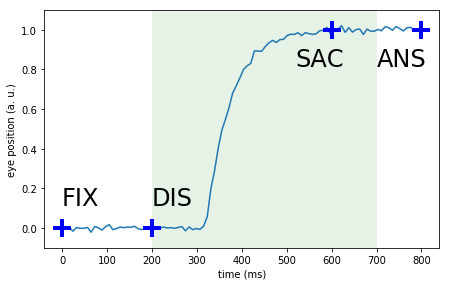

In [12]:
def panel_B(fig=None, axs=None, N_time=100, offset=.15, fontsize=24, ms=18, markeredgewidth=4, alpha=.1):
    if fig is None:
        fig, axs = plt.subplots(1, 1, figsize=(figwidth/2, figwidth/phi/2))
    
    time = np.linspace(0, 800, N_time)
    latency = 320
    EM = 1. - np.exp(- (time-latency) / 54. ) 

    EM[time<latency] = 0
    EM += .01 * np.random.randn(N_time)

    start, sac, end = 200, 600, 700
    axs.plot(time, EM)
    axs.plot([start], [0], '+', color='b', ms=ms, markeredgewidth=markeredgewidth)
    axs.plot([sac], [1], '+', color='b', ms=ms, markeredgewidth=markeredgewidth)
    axs.plot([0], [0], '+', color='b', ms=ms, markeredgewidth=markeredgewidth)
    axs.plot([800], [1], '+', color='b', ms=ms, markeredgewidth=markeredgewidth)
    opts = dict(fontsize=fontsize,
          bbox={'facecolor':'white','alpha':0,'edgecolor':'none','pad':1},
          ha='left', va='center')
    axs.text(0, offset, 'FIX', **opts)
    axs.text(start, offset, 'DIS', **opts)
    axs.text(sac-80, 1-offset, 'SAC', **opts)
    axs.text(700, 1-offset, 'ANS', **opts)
    axs.fill_between([start, end], y1=1.15, y2=-.15, facecolor='g', alpha=alpha)
    axs.set_ylim([-.1, 1.1])
    axs.set_xlabel('time (ms)')
    axs.set_ylabel('eye position (a. u.)')
    return fig, axs

fig_B, axs_B = panel_B()

# foveation

In [13]:
from retina import Retina
r = Retina(args)

In [14]:
idx = 4
i_offset, j_offset = -29, 21
data_fullfield = d.place_object(data[idx, 0, :, :].numpy(), i_offset, j_offset)
data_fullfield_0 = d.place_object(data[0, 0, :, :].numpy(), 0, 0)

data_retina = r.retina(data_fullfield)
data_retina_0   = r.retina(data_fullfield_0)

im_0 = r.retina_invert(data_retina_0)
im = r.retina_invert(data_retina)

In [15]:
r.retina_transform_vector.shape

(1920, 16384)

In [16]:
r.retina_inverse_transform.shape

(16384, 1920)

In [17]:
data_retina.shape

(1920,)

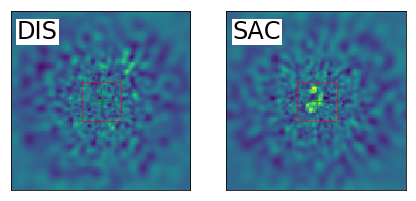

In [18]:
def panel_C(fig=None, axs=None,):
    N_pic = args.N_pic
    w = data[idx, 0, :, :].numpy().shape[0]
    rmin = min((im.min(), im_0.min()))
    rmax = max((im.max(), im_0.max()))
    if fig is None:
        fig, axs = plt.subplots(1, 2, figsize=(figwidth/2, figwidth/phi/2))
    for ax, text in zip(axs, texts[1:3]):
        if text == 'DIS':
            ax = r.show(ax, im, rmin=rmin, rmax=rmax)
        else:
            ax = r.show(ax, im_0, rmin=rmin, rmax=rmax)

        ax.text(4, 15, text, fontsize=24,
              bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
              ha='left', va='center') 

    return fig, axs
fig_C, axs_C = panel_C()
# fig_B.savefig(figname + '.pdf')

# summary

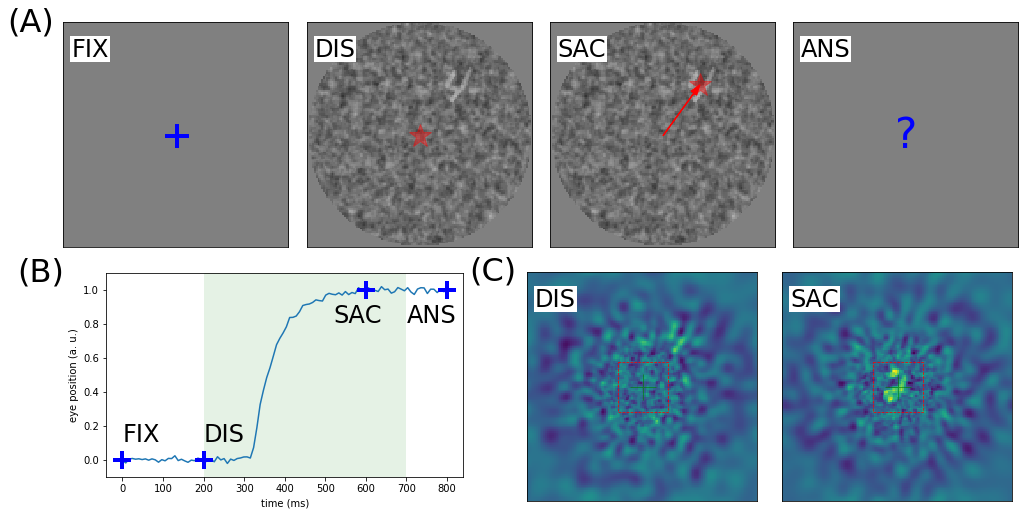

In [19]:
# fig = plt.figure(figsize = (21, 13))
fig, axs = plt.subplots(2, 4, figsize = (figwidth, figwidth/2), constrained_layout=True)
    
fig, axs_A = panel_A(fig=fig, axs=axs[0])
fig, axs_B = panel_B(fig=fig, axs=axs[1][0])
fig, axs_C = panel_C(fig=fig, axs=axs[1][1:3])
axs[1][3].remove()
# pos : [left, bottom, width, height] =    The new position of the in `.Figure` coordinates.
axs_B.set_position([0.1, 0.0725, .35, 0.4])
axs_C[0].set_position([0.4, .025, .45, .45])
axs_C[1].set_position([0.65, .025, .45, .45])
offset = -.25
for ax, text, x, y in [[axs_A[0], 'A', offset, 1], [axs_B, 'B', offset, 1], [axs_C[0], 'C', offset, 1]]:
    ax.text(x, y, '(' + text + ')', fontsize=32,
              bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
              ha='left', va='center', transform=ax.transAxes) 

#plt.tight_layout()
fig.savefig(figname + '.pdf', bbox_inches='tight', pad_inches=0.1)

# post-processing

In [20]:
!convert  -density {dpi_export} {figname}.pdf {figname}.jpg
!convert  -density {dpi_export} {figname}.pdf {figname}.png
#!convert  -density {dpi_export} -resize 5400  -units pixelsperinch -flatten  -compress lzw  -depth 8 {fname}.pdf {fname}.tiff

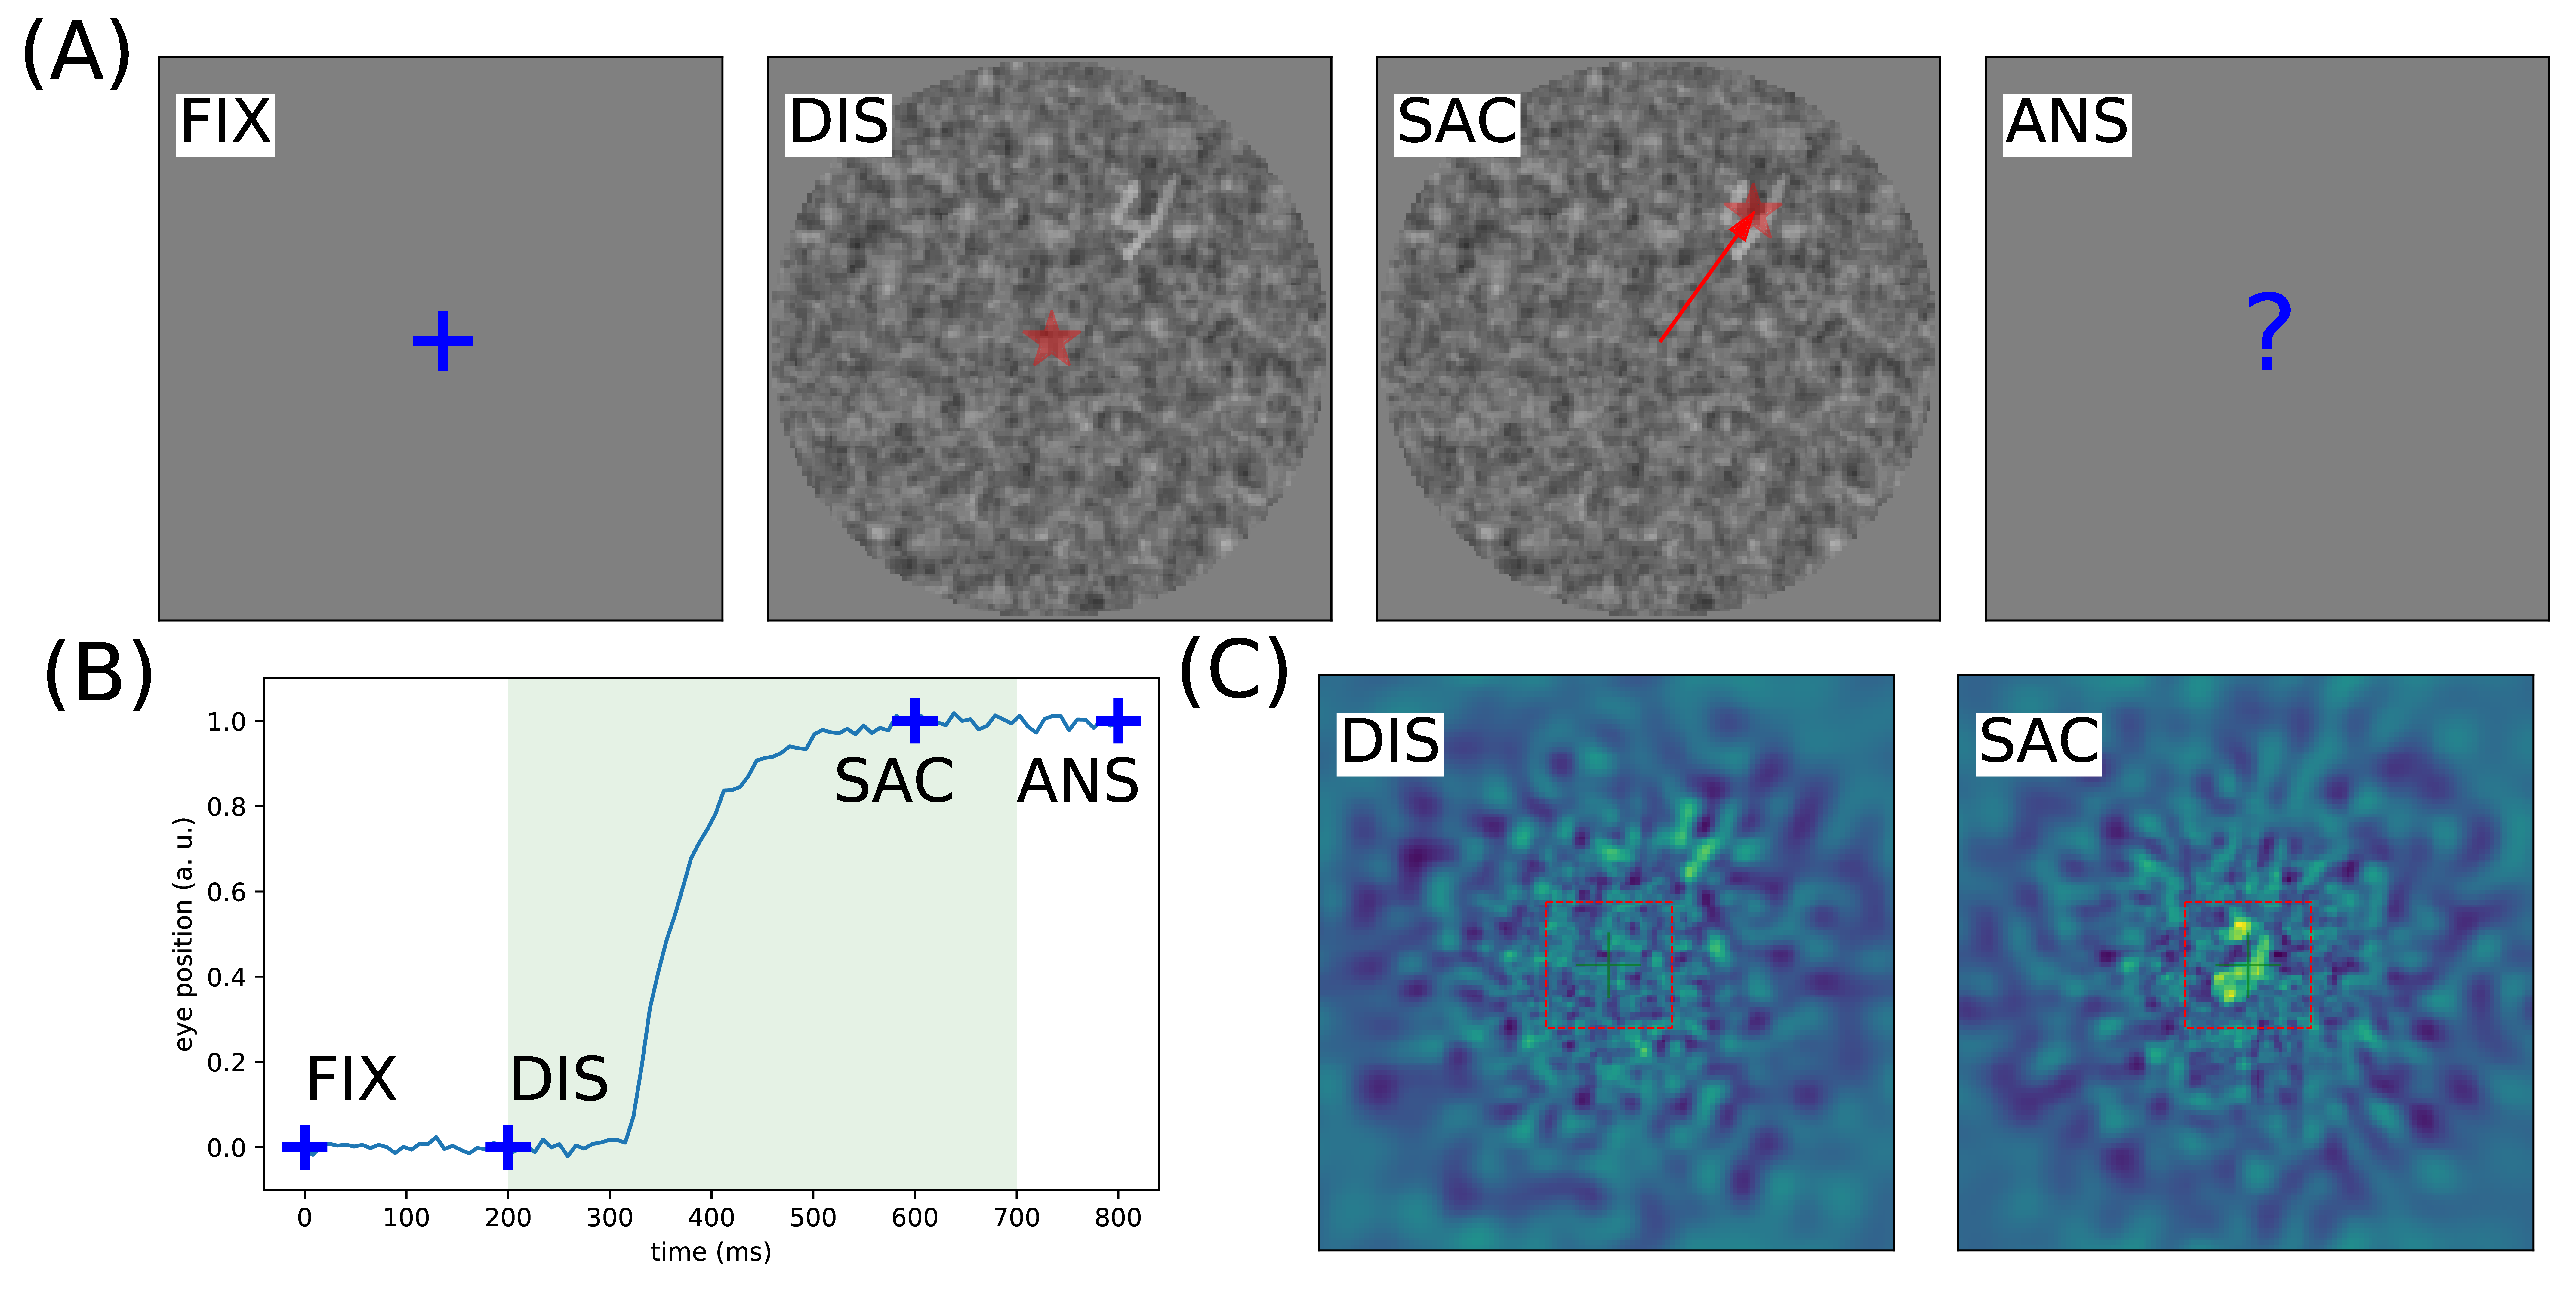

In [21]:
from IPython.display import Image
Image('{figname}.png'.format(figname=figname))

In [22]:
!ls  -l {figname}*

-rw-r--r--  1 laurentperrinet  staff  2233774 Mar 12 15:17 ../paper/fig_intro.jpg
-rw-r--r--  1 laurentperrinet  staff   111062 Mar 12 15:17 ../paper/fig_intro.pdf
-rw-r--r--  1 laurentperrinet  staff   468908 Mar 12 15:17 ../paper/fig_intro.png


## Version used

In [23]:
%load_ext version_information
%version_information numpy, shl_scripts

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.7.2 64bit [Clang 10.0.0 (clang-1000.11.45.5)]
IPython 7.3.0
OS Darwin 18.2.0 x86_64 i386 64bit
numpy 1.16.2
shl_scripts 20171221
Tue Mar 12 15:17:54 2019 CET